In [1]:
import lightkurve as lk
from lightkurve import search_lightcurvefile
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import csv
import pandas as pd
from wotan import flatten
import os, sys
from foldedleastsquares import (
    transitleastsquares,
    cleaned_array,
    catalog_info,
    transit_mask
    )


/home/fran/anaconda3/lib/python3.8/site-packages/lightkurve/config/__init__.py:119: UserWarning: The default Lightkurve cache directory, used by download(), etc., has been moved to /home/fran/.lightkurve/cache. Please move all the files in the legacy directory /home/fran/.lightkurve-cache to the new location and remove the legacy directory. Refer to https://docs.lightkurve.org/reference/config.html#default-cache-directory-migration for more information.
  warnings.warn(


In [2]:
TIC_ID = 259377017  # TIC_ID of our candidate (TOI-270; https://exofop.ipac.caltech.edu/tess/target.php?id=259377017)
# Check and download data you want 
lcf_120= lk.search_lightcurve('TIC '+str(TIC_ID), mission="tess",author='spoc',cadence=120,sector=4).download_all() #explore and download the available data from SPOC for 120s 
#display what you found
print('Data for 120s: ',lcf_120)

Data for 120s:  LightCurveCollection of 1 objects:
    0: <TessLightCurve LABEL="TIC 259377017" SECTOR=4 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>


In [3]:
#convert the data in a lightkurve object which is very easy to handle 

lc=lcf_120.stitch().remove_nans() # remove of the nans 
flux=lc.flux
flux_err=lc.flux_err
time=lc.time
lc_new=lk.LightCurve(time=time, flux=flux,flux_err=flux_err) # we create a lightkurve object
flux_clean=lc_new.remove_outliers(sigma_lower=float('inf'), sigma_upper=float('inf')) # if you want to remove some outliers, here not done. 


Text(1410.9143461769095, 1.009, 'Sec. 4')

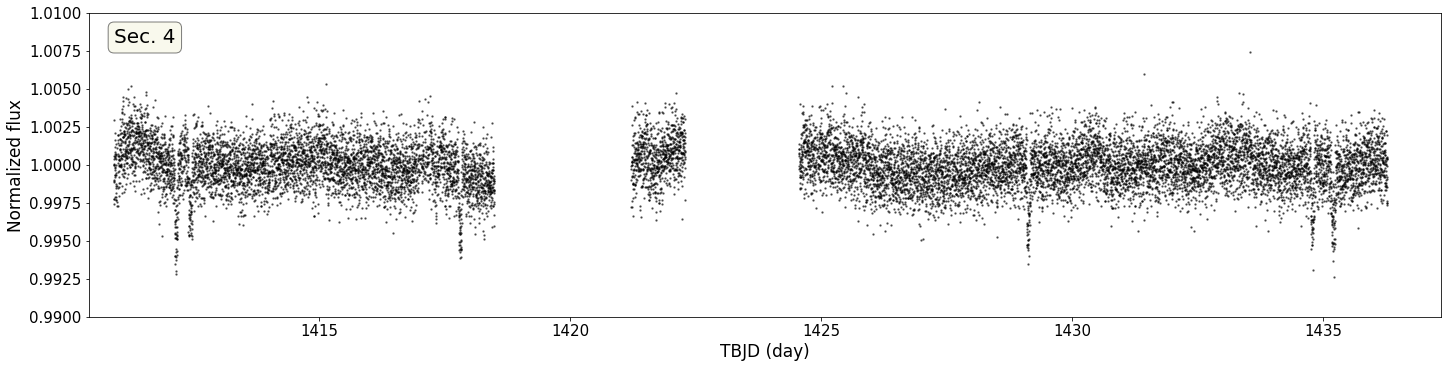

In [4]:
#Let's plot the data 

color1='black'
color2='firebrick'


fig1, (ax1) = plt.subplots(1, 1, figsize=(20,5),constrained_layout=True)
fig1.patch.set_facecolor('xkcd:white')
props = dict(boxstyle='round', facecolor='beige', alpha=0.5)

ax1.scatter(flux_clean.time.value, flux_clean.flux.value, color=color1, s=2, alpha=0.5,rasterized=True)
ax1.set_xlim(lcf_120[0]['time'][0].value-0.5,lcf_120[0]['time'][-1].value+0.5)
ax1.set_ylim(0.990,1.01)
ax1.set_ylabel('Normalized flux',fontsize=17)
ax1.set_xlabel('TBJD (day)',fontsize=17)
ax1.tick_params(axis='both', which='major', labelsize=15)
ax1.text(lcf_120[0]['time'][0].value+0.01, 1.009, "Sec. 4", fontsize=20, verticalalignment='top', bbox=props)


In [5]:
# let's work with 3 light curves: the PDC_SAP (original), window_length=0.01, and window_length=0.3 (one of the best in the detrending_lightcurves.ipynb)

 
flatten_lc_001, trend_lc_001  = flatten(flux_clean.time.value, flux_clean.flux.value, window_length=0.01, return_trend=True, method='biweight',break_tolerance=0.5)
flatten_lc_03, trend_lc_03  = flatten(flux_clean.time.value, flux_clean.flux.value, window_length=0.3, return_trend=True, method='biweight',break_tolerance=0.5)



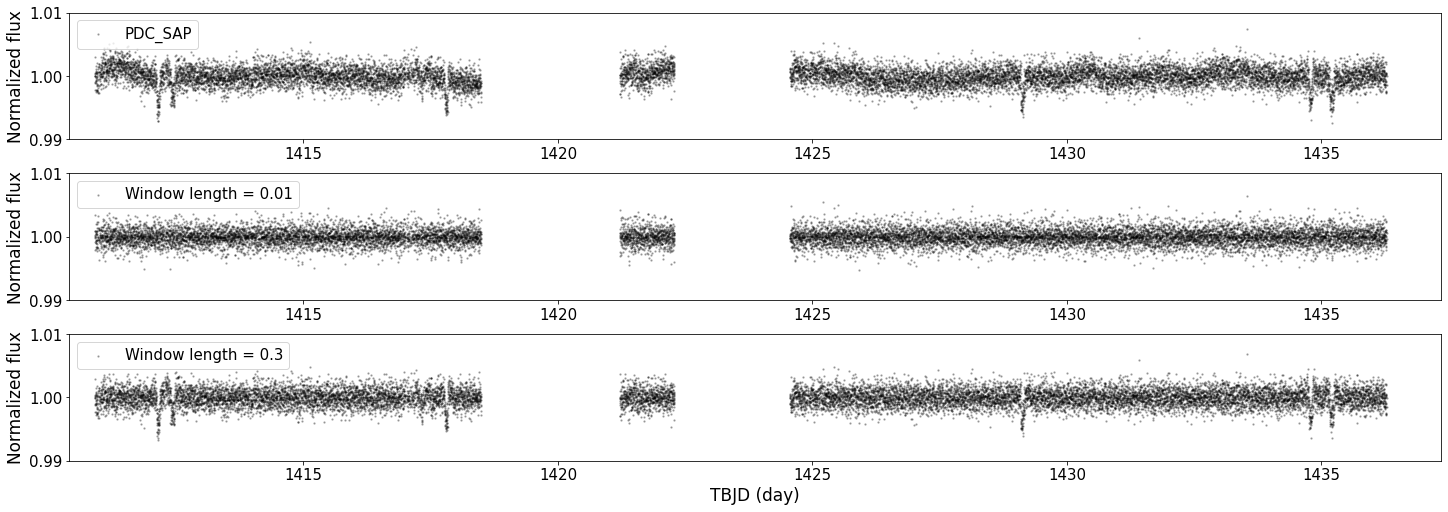

In [6]:
# plot the three light curves over which we will search for planets

fig1, (ax1,ax2,ax3) = plt.subplots(3, 1, figsize=(20,7),constrained_layout=True)
fig1.patch.set_facecolor('xkcd:white')
props = dict(boxstyle='round', facecolor='beige', alpha=0.5)

ax1.scatter(flux_clean.time.value, flux_clean.flux.value, color=color1, s=2, alpha=0.25,rasterized=True, label='PDC_SAP')
ax1.set_xlim(lcf_120[0]['time'][0].value-0.5,lcf_120[0]['time'][-1].value+0.5)
ax1.set_ylim(0.990,1.01)
ax1.set_ylabel('Normalized flux',fontsize=17)
ax1.tick_params(axis='both', which='major', labelsize=15)

ax2.scatter(flux_clean.time.value, flatten_lc_001, color=color1, s=2, alpha=0.25,rasterized=True,label='Window length = 0.01')
ax2.set_xlim(lcf_120[0]['time'][0].value-0.5,lcf_120[0]['time'][-1].value+0.5)
ax2.set_ylim(0.990,1.01)
ax2.set_ylabel('Normalized flux',fontsize=17)
ax2.tick_params(axis='both', which='major', labelsize=15)

ax3.scatter(flux_clean.time.value, flatten_lc_03, color=color1, s=2, alpha=0.25,rasterized=True,label='Window length = 0.3')
ax3.set_xlim(lcf_120[0]['time'][0].value-0.5,lcf_120[0]['time'][-1].value+0.5)
ax3.set_ylim(0.990,1.01)
ax3.set_ylabel('Normalized flux',fontsize=17)
ax3.set_xlabel('TBJD (day)',fontsize=17)
ax3.tick_params(axis='both', which='major', labelsize=15)
ax3.set_xlabel('TBJD (day)',fontsize=17)

# Add legends
ax1.legend(fontsize=15,loc='upper left')
ax2.legend(fontsize=15,loc='upper left')
ax3.legend(fontsize=15,loc='upper left')

In [7]:
# To optimize the search we need some stellar parameters, which we import from the TESS imput catalogue 

ab, mass, mass_lower, mass_upper, radius, radius_lower, radius_upper = catalog_info(TIC_ID=TIC_ID)

mass_min=mass-mass_lower
mass_max=mass+mass_upper
radius_min=radius-radius_lower
radius_max=radius+radius_upper

print('\n STELLAR PROPERTIES (IN SOLAR UNITS) FOR THE SIGNAL SEARCH')
print('====================================================================\n')
print('limb-darkening estimates using quadratic LD (a,b)=', ab)
print('mass =', mass)
print('mass_min =', mass_min)
print('mass_max =', mass_max)
print('radius =', radius)
print('radius_min =', radius_min)
print('radius_max =', radius_max)


 STELLAR PROPERTIES (IN SOLAR UNITS) FOR THE SIGNAL SEARCH

limb-darkening estimates using quadratic LD (a,b)= (0.1604, 0.4325)
mass = 0.362274
mass_min = 0.341783
mass_max = 0.38276499999999997
radius = 0.374358
radius_min = 0.3628623
radius_max = 0.3858537


In [8]:
# Now we run the TLS algorithm to search for planetary candidates using the PDC_SAP light curve, that is, the original light curve without any detrend

model = transitleastsquares(flux_clean.time.value, flux_clean.flux.value)
results = model.power(u=ab, M_star=mass, M_star_min=mass_min, M_star_max=mass_max, R_star=radius, R_star_min=radius_min, R_star_max=radius_max, n_transits_min=2, show_progress_bar=True)

Transit Least Squares TLS 1.0.42 (12 April 2023)


  0%|          | 0/6937 periods | 00:00<?

Creating model cache for 37 durations
Searching 14445 data points, 6937 periods from 0.229 to 12.688 days
Using all 8 CPU threads


100%|██████████| 6937/6937 periods | 01:59<00:00
  0%|          | 0/7445 [00:00<?, ?it/s]

Searching for best T0 for period 5.66166 days


100%|██████████| 7445/7445 [00:09<00:00, 798.21it/s]


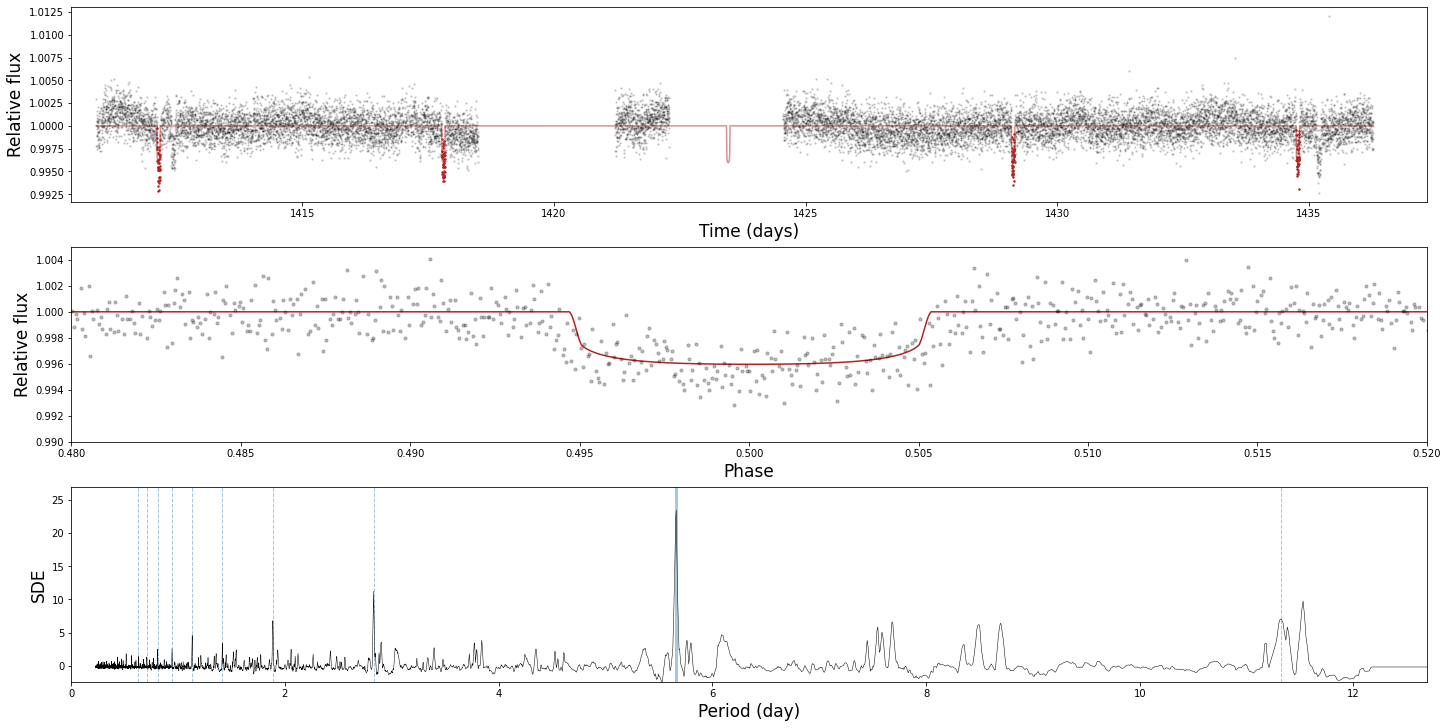

In [9]:
# let's now to explore the results 

fig1, (ax1,ax2,ax3) = plt.subplots(3, 1, figsize=(20,10),constrained_layout=True)
fig1.patch.set_facecolor('xkcd:white')

# let's see which transits were found 
in_transit = transit_mask(flux_clean.time.value, results.period, results.duration, results.T0)
ax1.scatter(flux_clean.time.value[in_transit], flux_clean.flux.value[in_transit], color=color2, s=2, zorder=0)
ax1.scatter(flux_clean.time.value[~in_transit], flux_clean.flux.value[~in_transit], color=color1, alpha=0.15, s=2, zorder=0)
ax1.plot(results.model_lightcurve_time, results.model_lightcurve_model, alpha=0.5, color=color2, zorder=1)
ax1.set_xlim(lcf_120[0]['time'][0].value-0.5,lcf_120[0]['time'][-1].value+0.5)
ax1.set_ylabel('Relative flux',fontsize=17)
ax1.set_xlabel('Time (days)',fontsize=17)

# transit phase folded
ax2.plot(results.model_folded_phase, results.model_folded_model, color=color2)
ax2.scatter(results.folded_phase, results.folded_y, color=color1, s=10, alpha=0.25, zorder=2)
ax2.set_xlim(0.48, 0.52)
ax2.set_ylim(0.990, 1.005)
ax2.set_ylabel('Relative flux',fontsize=17)
ax2.set_xlabel('Phase',fontsize=17)

# SDE spectrum
ax3.axvline(results.period, alpha=0.4, lw=3)
ax3.set_ylim(np.min(results.power), np.max(results.power)*1.15)
for n in range(2, 10):
    ax3.axvline(n*results.period, alpha=0.4, lw=1, linestyle="dashed")
    ax3.axvline(results.period / n, alpha=0.4, lw=1, linestyle="dashed")

ax3.set_ylabel('SDE',fontsize=17)
ax3.set_xlabel('Period (day)',fontsize=17)
ax3.plot(results.periods, results.power, color='black', lw=0.5)
ax3.set_xlim(0, max(results.periods));

In [11]:
# let's explore some metrics

print('Period', format(results.period, '.5f'), 'd at T0=', results.T0)
print(len(results.transit_times), 'transit times in time series:', ['{0:0.5f}'.format(i) for i in results.transit_times])
print('Number of data points during each unique transit: ', results.per_transit_count)
print('The number of transits with intransit data points: ', results.distinct_transit_count)
print('The number of transits with no intransit data points: ', results.empty_transit_count)
print('Transit depth (mean): ', format(np.nanmean(results.transit_depths), '.5f'))
print('Transit duration (min): ', format(results.duration*24*60, '.5f'))
print('Transit depths (individual): ', results.transit_depths)
print('Transit depth uncertainties: ', results.transit_depths_uncertainties)
print('Signal-to-Noise (S/N): ', results.snr)
print('Signal-Detection-Efficiency (SDE): ', results.SDE)


Period 5.66166 d at T0= 1412.1402673284622
5 transit times in time series: ['1412.14027', '1417.80193', '1423.46359', '1429.12525', '1434.78691']
Number of data points during each unique transit:  [43. 43.  0. 43. 44.]
The number of transits with intransit data points:  4
The number of transits with no intransit data points:  1
Transit depth (mean):  0.99618
Transit duration (min):  86.92396
Transit depths (individual):  [0.9958342  0.99599317        nan 0.99624077 0.99666626]
Transit depth uncertainties:  [0.00024192 0.00019151        nan 0.00020479 0.00021912]
Signal-to-Noise (S/N):  34.22314939276183
Signal-Detection-Efficiency (SDE):  23.44174455129679


In [12]:
## TRY YOURSELF
#
# Now you can do the same search but using the others light curves (flatten_lc_001 and flatten_lc_03) and compare all the results.
#
# Which search provides the strongest detection? (largest S/R and SDE)
#

